<a href="https://colab.research.google.com/github/arthursl12/POC1/blob/main/POC2_FD001_MLP_optim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
%pip install scikeras;
%pip install -U tensorflow-addons;
%pip install scikit-optimize

In [ ]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import datetime

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import GroupKFold

from sklearn.base import BaseEstimator,RegressorMixin

In [ ]:
from skopt import BayesSearchCV

from skopt.space.space import Categorical, Integer, Real

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Masking

from tensorflow.keras.metrics import RootMeanSquaredError as RMSE

from keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import tensorflow_addons as tfa
from tensorflow_addons.metrics import RSquare as R2

from scikeras.wrappers import KerasRegressor

In [ ]:
sns.set_palette('colorblind')

In [ ]:
# Reproducibility
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
tf.config.experimental.enable_op_determinism()

In [ ]:
# Remove some tf warnings
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# Data Preparation

In [ ]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    IN_COLAB = True
    folder="/content/CMaps/"

    # Dataset Download 
    os.system('git clone https://github.com/arthursl12/dataset_2')
    os.system('mv /content/dataset_2/CMaps /content/CMaps')
    os.system('mv /content/dataset_2/data_processing /content/data_processing')
    os.system('rm -rf dataset_2')
else:
    print('Not running on CoLab')
    IN_COLAB = False
    folder="CMaps/"
    %cd dataset_2/

In [ ]:
from data_processing.processing import DatasetProcessing
from data_processing.training import HyperparameterSearch, reclipper_scorer
from data_processing.eval import Evaluation

In [ ]:
proc = DatasetProcessing()

## Data Integration

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:  

1) unit number   
2) time, in cycles  
3) operational setting 1  
4) operational setting 2  
5) operational setting 3    
6) sensor measurement 1    
7) sensor measurement 2  
...  
26) sensor measurement 20


There are 6 conditions (or combinations) which the 3 operational settings can take.  
Condition 1: Altitude = 0, Mach Number = 0, TRA = 100  
Condition 2: Altitude = 10, Mach Number = 0.25, TRA = 100  
Condition 3: Altitude = 20, Mach Number = 0.7 TRA = 100  
Condition 4: Altitude = 25, Mach Number = 0.62, TRA = 60  
Condition 5: Altitude = 35 Mach Number = 0.84, TRA = 100  
Condition 6: Altitude = 42, Mach Number = 0.84, TRA = 100  
  
There is slight variation in all these conditions so you may get numbers like 24.453 instead of 25 exactly.

FD001: Condition 1 only  
FD002: Mix of all the conditions  
FD003: Condition 1 only  
FD004: Mix of all conditions  


In [ ]:
index_cols, settings_cols, sensors_cols, cols = proc.column_names()
train, test, y_test = proc.read_dataset(1,folder=folder)
train

## Preprocessing

### Validation Set

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

def train_val_split(train):
    gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  
    for idx_train, idx_val in gss.split(train,groups=train["unit_number"]):
        # print('train_split_engines', train.iloc[idx_train]['unit_number'].unique(), '\n')
        # print('validate_split_engines', train.iloc[idx_val]['unit_number'].unique(), '\n')

        df_train = train.iloc[idx_train].copy()
        df_val = train.iloc[idx_val].copy()

    return df_train, df_val

In [ ]:
df_train, df_val = train_val_split(train)

In [ ]:
X_t_train, y_t_train = proc.X_y_train_divide(df_train)
X_t_val, y_t_val = proc.X_y_train_divide(df_val)

### Test Set Transformation 
Test set has samples for all cycles, but has annotations only for last one

In [ ]:
test.shape, y_test.shape

In [ ]:
test_last = proc.transform_test(test)
test_last.head()

In [ ]:
X_test = test_last

### Remaining Useful Life (RUL)

In [ ]:
train = proc.add_remaining_useful_life_linear(train)
train[index_cols+['RUL']].head()

## Attributes and target separation

In [ ]:
X_train, y_train = proc.X_y_train_divide(train)

In [ ]:
y_train.head()

In [ ]:
X_train.head()

## Training and Evaluation functions

In [ ]:
eval = Evaluation()

In [ ]:
search = HyperparameterSearch()

# MLP Construction

## Callbacks

In [ ]:
# Early Stopping Callback
es = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                      patience=5, restore_best_weights=True)

In [ ]:
# Printing Callback
def printLog(epoch, logs):
    print(
        f"E {epoch+1}\t: loss={logs['loss']:.3f}, "+
        f"rmse={logs['root_mean_squared_error']:.3f}, "+
        f"r2={logs['r_square']:.3f}; "+
        f"v_loss={logs['val_loss']:.3f}, "+
        f"v_rmse={logs['val_root_mean_squared_error']:.3f}, "+
        f"v_r2={logs['val_r_square']:.3f}; "
    )

printerCallback = LambdaCallback(on_epoch_end=printLog)

## Auxiliary HyperParameters

In [ ]:
layer_sizes=[16,32,64,128,256,512]

In [ ]:
# Exponential Decay Schedules
ED1 = ExponentialDecay(initial_learning_rate=1e-2, name="ED1",
                       decay_steps=100000, decay_rate=0.96)
ED2 = ExponentialDecay(initial_learning_rate=1e-2, name="ED2",
                       decay_steps=100000, decay_rate=0.8)
ED3 = ExponentialDecay(initial_learning_rate=1e-1, name="ED3",
                       decay_steps=100000, decay_rate=0.96)

In [ ]:
# Generation of list combinations
from itertools import chain, permutations

def all_permutations(lst, size):
    result = list(chain.from_iterable([permutations(lst, x) for x in range(len(lst)+1)]))
    out = []
    for r in result:
        if (len(r) == size):
            out.append(list(r))
    return out

## Constants

In [ ]:
# X_train must include indices
train3 = train.copy()
X_train_ = train3.drop(columns=[index_cols[1]]+["RUL"])

In [ ]:
INPUT_SHAPE = 0

## Wrapper

In [ ]:
from sys import is_finalizing
from sklearn.metrics import r2_score

class MLPWrapperRegressor(BaseEstimator,RegressorMixin):
    def __init__(self, basemodel=None, clip_y=-1,
                 include_settings=False, poly_degree=1,
                 scaler=StandardScaler()):
        # Base parameters
        self.basemodel = basemodel
        self.clip_y = clip_y
        self.poly_degree = poly_degree
        self.include_settings = include_settings

        # Column indexers
        self.feature_cols = sensors_cols
        if(include_settings):
            self.feature_cols = settings_cols + self.feature_cols
        self.base_feature_cols = self.feature_cols

        # Scaler and PolyFeatures transformers
        self.scaler = scaler
        self.polyft = PolynomialFeatures(degree=self.poly_degree, 
                                         include_bias=False)

    def clean_cols(self,df):
        if("unit_number" in df.columns): del df["unit_number"]
        if("unit_number" in df.columns): del df["unit_number"]
        if("time" in df.columns): del df["time"]
        if((not self.include_settings)): 
            for col in settings_cols:
                if(col in df.columns): del df[col]
        return df

    def fit(self, X=None, y=None):
        # Drop irrelevant column
        data = pd.DataFrame(X)
        data = self.clean_cols(data)
        
        # Apply polynomial features and add them to the dataframe
        transf = self.polyft.fit_transform(data)
        data = pd.DataFrame(transf, columns=
                              self.polyft.get_feature_names_out())
        self.feature_cols = list(self.polyft.get_feature_names_out())

        # Scale the data
        data = self.scaler.fit_transform(data)
        data = pd.DataFrame(data, 
                            columns=self.scaler.get_feature_names_out())
        X_train = data.copy()
        
        # Clip and transform labels
        data2 = pd.DataFrame(y, columns=["RUL"])
        if (self.clip_y > 0):
            data2["RUL"].clip(upper=self.clip_y, inplace=True)
        y_train = data2

        # Update input shape for future use
        global INPUT_SHAPE
        INPUT_SHAPE = X_train.shape[1]

        # Fit model
        self.basemodel.fit(X_train,y_train)
        return self
        
    def predict(self, X=None):
        # Perform transformation, if not done
        if (len(X.columns) != len(self.feature_cols)):
            X_train = self.transform_features(X)
        else:
            X_train = X
        return self.basemodel.predict(X_train)

    def transform_features(self, df):
        # Drop irrelevant column
        data = pd.DataFrame(df)
        data = self.clean_cols(data)
        
        # Apply polynomial features and add them to the dataframe
        transf = self.polyft.transform(data)
        data = pd.DataFrame(transf, columns=
                              self.polyft.get_feature_names_out())
        # self.feature_cols = list(self.polyft.get_feature_names_out())

        # Scale the data
        data = self.scaler.transform(data)
        data = pd.DataFrame(data, 
                            columns=self.scaler.get_feature_names_out())
        return data

    def score(self, X, y, sample_weight=None):
        X_test = self.transform_features(X)

        # Clip and transform labels
        data2 = pd.DataFrame(y, columns=["RUL"])
        if (self.clip_y > 0):
            data2["RUL"].clip(upper=self.clip_y, inplace=True)
        y_test = data2

        # Predict on test data
        y_pred = self.predict(X_test)
        return r2_score(y_test, y_pred, sample_weight=sample_weight)

## Test Data

In [ ]:
def scale_test(test,model):
    test2 = pd.DataFrame(test)
    test2 = model.clean_cols(test2)

    # Apply polynomial features
    transf = model.polyft.transform(test2)
    test2 = pd.DataFrame(transf, 
                         columns=model.polyft.get_feature_names_out())

    # Scale the data (with train data parameters)
    test2 = model.scaler.transform(test2)
    test2 = pd.DataFrame(test2, 
                         columns=model.polyft.get_feature_names_out())
    return test2

## Constructor

In [ ]:
def create_model(optim=Adam, learning_rate=1e-3, 
                 layer1=32  , activation1="tanh"    , dropout1=0.1,
                 layer2=None, activation2="tanh"    , dropout2=0.1,
                 layer3=None, activation3="tanh"    , dropout3=0.1,
                 layer4=None, activation4="tanh"    , dropout4=0.1,
                 print_summary=False, loss='mean_squared_error',
                 metrics=[tf.keras.metrics.MeanSquaredError()]):
    model = Sequential()

    # Fully Connected Layer
    model.add(Dense(layer1, input_dim=INPUT_SHAPE, activation=activation1))
    model.add(Dropout(dropout1))

    # Additional hidden layers
    if(layer2 is not None):
        model.add(Dense(layer2, activation=activation2))
        model.add(Dropout(dropout2))
        if (layer3 is not None):
            model.add(Dense(layer3, activation=activation3))
            model.add(Dropout(dropout3))
            if (layer4 is not None):
                model.add(Dense(layer4, activation=activation4))
                model.add(Dropout(dropout4))

    # Output Layer
    model.add(Dense(1))

    model.compile(loss=loss, optimizer=optim(learning_rate=learning_rate), 
                  metrics=metrics)
    
    if(print_summary): model.summary()
    return model

# HyperParameter Tuning

In [ ]:
CLIP=-1

model = MLPWrapperRegressor(
        clip_y=CLIP,scaler=MinMaxScaler(),
        basemodel=
            KerasRegressor(model=create_model,
                           batch_size=64,
                           epochs=1,
                           validation_split=0.2, 
                           model__activation1='relu',
                           model__dropout1=0.5, 
                           model__layer1=512, 
                           model__layer2=64,
                           model__layer3=64,
                           model__layer4=64,
                           model__learning_rate=0.01,
                           model__optim=Adam,
                        #    verbose=0, callbacks=[es,printerCallback],
                           verbose=0, callbacks=[es],
                           model__metrics=[RMSE(), R2()],
                           model__loss='mse',
                           print_summary=False
                           )
    )

In [ ]:
# ~3h (LSTM)
# ~45min (MLP)
GRID_SEARCH = True
if (GRID_SEARCH):
    param_distributions = {
        # "clip_y": Integer(80,140),
        # "poly_degree": Categorical([2,3]),
        "scaler": Categorical([MinMaxScaler(),StandardScaler()]),
        "basemodel__epochs": Integer(1,50),
        "basemodel__validation_split":Real(0.1,0.9),
        "basemodel__batch_size": Integer(32,512),
        "basemodel__model__optim":Categorical([Adam,RMSprop]),
        "basemodel__model__learning_rate": Real(1e-4, 1e-2),
        
        "basemodel__model__layer1": Integer(16,512),
        "basemodel__model__activation1": Categorical(["relu","elu","selu","tanh", "sigmoid"]),
        "basemodel__model__dropout1": Real(0.1,0.9),

        "basemodel__model__layer2": Integer(16,512),
        "basemodel__model__activation2": Categorical(["relu","elu","selu","tanh", "sigmoid"]),
        "basemodel__model__dropout2": Real(0.1,0.9),

        "basemodel__model__layer3": Integer(16,512),
        "basemodel__model__activation3": Categorical(["relu","elu","selu","tanh", "sigmoid"]),
        "basemodel__model__dropout3": Real(0.1,0.9),

        "basemodel__model__layer4": Integer(16,512),
        "basemodel__model__activation4": Categorical(["relu","elu","selu","tanh", "sigmoid"]),
        "basemodel__model__dropout4": Real(0.1,0.9),
    }
    gcv = GroupKFold(n_splits=3)
    groups=X_train_['unit_number']
    bss = BayesSearchCV(model, param_distributions, 
                        verbose=3, n_jobs=1, refit=False,
                        cv=gcv.split(X_train_, groups=groups), n_iter=45)
    model = bss.fit(X_train_, y_train)
    
    # print(bss.best_estimator_)
    print("Finished:", datetime.datetime.now())

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END basemodel__batch_size=491, basemodel__epochs=35, basemodel__model__activation1=sigmoid, basemodel__model__activation2=selu, basemodel__model__activation3=selu, basemodel__model__activation4=relu, basemodel__model__dropout1=0.1000488406021388, basemodel__model__dropout2=0.3965483901301635, basemodel__model__dropout3=0.5755031308731086, basemodel__model__dropout4=0.24072512447023642, basemodel__model__layer1=397, basemodel__model__layer2=236, basemodel__model__layer3=78, basemodel__model__layer4=108, basemodel__model__learning_rate=0.003739593550034222, basemodel__model__optim=<class 'keras.optimizer_v2.adam.Adam'>, basemodel__validation_split=0.6969019934333063, scaler=StandardScaler();, score=-0.074 total time=   6.0s
[CV 2/3] END basemodel__batch_size=491, basemodel__epochs=35, basemodel__model__activation1=sigmoid, basemodel__model__activation2=selu, basemodel__model__activation3=selu, basemodel__model__activatio

In [ ]:
# print(bss.best_estimator_)
print(bss.best_score_)
print(bss.best_params_)
print("Finished:", datetime.datetime.now())

0.6177119361436677
OrderedDict([('basemodel__batch_size', 127), ('basemodel__epochs', 17), ('basemodel__model__activation1', 'relu'), ('basemodel__model__activation2', 'sigmoid'), ('basemodel__model__activation3', 'elu'), ('basemodel__model__activation4', 'elu'), ('basemodel__model__dropout1', 0.405658593077186), ('basemodel__model__dropout2', 0.3589949636608206), ('basemodel__model__dropout3', 0.4633066337493309), ('basemodel__model__dropout4', 0.32587881379978234), ('basemodel__model__layer1', 308), ('basemodel__model__layer2', 442), ('basemodel__model__layer3', 301), ('basemodel__model__layer4', 153), ('basemodel__model__learning_rate', 0.0038661981642895585), ('basemodel__model__optim', <class 'keras.optimizer_v2.rmsprop.RMSprop'>), ('basemodel__validation_split', 0.14630628708453258), ('scaler', StandardScaler())])
Finished: 2022-10-14 17:51:26.151485


Finished: 2022-10-14 17:51:28.602326


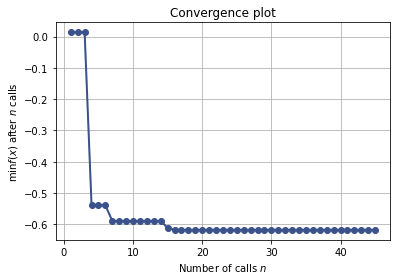

In [ ]:
from skopt.plots import plot_convergence

plot_convergence(bss.optimizer_results_)
print("Finished:", datetime.datetime.now())

In [ ]:
bss.best_params_

OrderedDict([('basemodel__batch_size', 127),
             ('basemodel__epochs', 17),
             ('basemodel__model__activation1', 'relu'),
             ('basemodel__model__activation2', 'sigmoid'),
             ('basemodel__model__activation3', 'elu'),
             ('basemodel__model__activation4', 'elu'),
             ('basemodel__model__dropout1', 0.405658593077186),
             ('basemodel__model__dropout2', 0.3589949636608206),
             ('basemodel__model__dropout3', 0.4633066337493309),
             ('basemodel__model__dropout4', 0.32587881379978234),
             ('basemodel__model__layer1', 308),
             ('basemodel__model__layer2', 442),
             ('basemodel__model__layer3', 301),
             ('basemodel__model__layer4', 153),
             ('basemodel__model__learning_rate', 0.0038661981642895585),
             ('basemodel__model__optim', keras.optimizer_v2.rmsprop.RMSprop),
             ('basemodel__validation_split', 0.14630628708453258),
             ('scale

# MLP 1-layer 



## Linear RUL

Score: 0.6275937811619965  
Test: 0.504
```
('basemodel__batch_size', 262),
('basemodel__epochs', 47),
('basemodel__model__activation', 'relu'),
('basemodel__model__dropout', 0.42198962995190514),
('basemodel__model__layer1', 512),
('basemodel__model__learning_rate', 0.00528953958947019),
('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
('basemodel__validation_split', 0.17975244796806303),
('scaler', StandardScaler())
```


## Non-Linear RUL
Score: 0.8670568151811345  
Test: 0.865
```
('basemodel__batch_size', 32),
('basemodel__epochs', 50),
('basemodel__model__activation', 'sigmoid'),
('basemodel__model__dropout', 0.1),
('basemodel__model__layer1', 450),
('basemodel__model__learning_rate', 0.006977518145392822),
('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
('basemodel__validation_split', 0.1),
('clip_y', 80),
('scaler', MinMaxScaler())
```

## Linear RUL + Poly
Score: 0.6307902416968273  
Test: 0.289
```
('basemodel__batch_size', 197),
('basemodel__epochs', 41),
('basemodel__model__activation', 'relu'),
('basemodel__model__dropout', 0.1),
('basemodel__model__layer1', 400),
('basemodel__model__learning_rate', 0.01),
('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
('basemodel__validation_split', 0.1),
('poly_degree', 2),
('scaler', StandardScaler())
```

## Non-Linear RUL + Poly
Score: 0.8693404879366771  
Test: 0.874
```
('basemodel__batch_size', 278),
('basemodel__epochs', 50),
('basemodel__model__activation', 'relu'),
('basemodel__model__dropout', 0.1),
('basemodel__model__layer1', 469),
('basemodel__model__learning_rate', 0.002874922426530888),
('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
('basemodel__validation_split', 0.1),
('clip_y', 80),
('poly_degree', 2),
('scaler', StandardScaler())
```




# MLP 2-layer 



## Linear RUL

Score: 0.6272545475290355  
Test: 0.497
```
('basemodel__batch_size', 256),
('basemodel__epochs', 15),
('basemodel__model__activation', 'sigmoid'),
('basemodel__model__dropout', 0.3130272595130772),
('basemodel__model__layer1', 396),
('basemodel__model__layer2', 200),
('basemodel__model__learning_rate', 0.004279444226455455),
('basemodel__model__optim', keras.optimizer_v2.rmsprop.RMSprop),
('basemodel__validation_split', 0.1),
('scaler', StandardScaler())
```

Similar to 1-layer, as poor as it was

## Non-Linear RUL
Score: 0.8673006780572581  
Test: 0.869
```
('basemodel__batch_size', 492),
('basemodel__epochs', 45),
('basemodel__model__activation', 'sigmoid'),
('basemodel__model__dropout', 0.12287812356959432),
('basemodel__model__layer1', 174),
('basemodel__model__layer2', 99),
('basemodel__model__learning_rate', 0.007788683565022675),
('basemodel__model__optim', keras.optimizer_v2.rmsprop.RMSprop),
('basemodel__validation_split', 0.417547927930325),
('clip_y', 80),
('scaler', StandardScaler())
```
As good as 1-layer, same clipping still

## Linear RUL + Poly
Score: 0.620623165113507  
Test: 0.317
```
([('basemodel__batch_size', 151),
('basemodel__epochs', 50),
('basemodel__model__activation', 'tanh'),
('basemodel__model__dropout', 0.4820078305171188),
('basemodel__model__layer1', 512),
('basemodel__model__layer2', 512),
('basemodel__model__learning_rate', 0.002743794579272865),
('basemodel__model__optim', keras.optimizer_v2.rmsprop.RMSprop),
('basemodel__validation_split', 0.1),
('poly_degree', 3),
('scaler', StandardScaler())
```

## Non-Linear RUL + Poly
Score: 0.8710647594112771  
Test: 0.847
```
('basemodel__batch_size', 108),
('basemodel__epochs', 17),
('basemodel__model__activation', 'tanh'),
('basemodel__model__dropout', 0.1),
('basemodel__model__layer1', 190),
('basemodel__model__layer2', 511),
('basemodel__model__learning_rate', 0.0025717804547879877),
('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
('basemodel__validation_split', 0.1),
('clip_y', 80),
('poly_degree', 3),
('scaler', StandardScaler())
```

# MLP 3-layer 



## Linear RUL

Score: 0.  8696275766179755  
Test: 0.
```
('basemodel__batch_size', 229),
('basemodel__epochs', 49),
('basemodel__model__activation', 'tanh'),
('basemodel__model__dropout', 0.29618065510851843),
('basemodel__model__layer1', 49),
('basemodel__model__layer2', 247),
('basemodel__model__layer3', 440),
('basemodel__model__learning_rate', 0.005372482164375986),
('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
('basemodel__validation_split', 0.34454860324430264),
('scaler', StandardScaler())
```

Similar to 1-layer, as poor as it was

## Non-Linear RUL
Score: 0.  8717596246219527  
Test: 0.
```
('basemodel__batch_size', 176),
('basemodel__epochs', 50),
('basemodel__model__activation', 'tanh'),
('basemodel__model__dropout', 0.3898721505208831),
('basemodel__model__layer1', 512),
('basemodel__model__layer2', 278),
('basemodel__model__layer3', 405),
('basemodel__model__learning_rate', 0.0001),
('basemodel__model__optim', keras.optimizer_v2.rmsprop.RMSprop),
('basemodel__validation_split', 0.1),
('clip_y', 138),
('scaler', StandardScaler())
```

## Linear RUL + Poly
Score: 0.  8650514903449471  
Test: 0.
```
('basemodel__batch_size', 186),
('basemodel__epochs', 48),
('basemodel__model__activation', 'relu'),
('basemodel__model__dropout', 0.1391581962274659),
('basemodel__model__layer1', 21),
('basemodel__model__layer2', 155),
('basemodel__model__layer3', 470),
('basemodel__model__learning_rate', 0.0073289126629601945),
('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
('basemodel__validation_split', 0.36967020819812124),
('poly_degree', 2),
('scaler', StandardScaler())
```

## Non-Linear RUL + Poly
Score: 0. 8685824286626458 
Test: 0.
```
('basemodel__batch_size', 341),
('basemodel__epochs', 17),
('basemodel__model__activation', 'tanh'),
('basemodel__model__dropout', 0.4873807075753994),
('basemodel__model__layer1', 327),
('basemodel__model__layer2', 178),
('basemodel__model__layer3', 137),
('basemodel__model__learning_rate', 0.004408412959948351),
('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
('basemodel__validation_split', 0.24273752933914083),
('clip_y', 128),
('poly_degree', 2),
('scaler', StandardScaler())
```

# MLP 4-layer 



## Linear RUL

Score: 0.8684757521280048    
Test: 0.
```
('basemodel__batch_size', 103),
('basemodel__epochs', 12),
('basemodel__model__activation', 'tanh'),
('basemodel__model__dropout', 0.3134822908558863),
('basemodel__model__layer1', 283),
('basemodel__model__layer2', 443),
('basemodel__model__layer3', 439),
('basemodel__model__layer4', 372),
('basemodel__model__learning_rate', 0.0032013417809996724),
('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
('basemodel__validation_split', 0.1),
('scaler', StandardScaler())
```



## Non-Linear RUL
Score: 0.8660106784286828    
Test: 0.
```
('basemodel__batch_size', 307),
('basemodel__epochs', 41),
('basemodel__model__activation', 'tanh'),
('basemodel__model__dropout', 0.5466264018626226),
('basemodel__model__layer1', 107),
('basemodel__model__layer2', 321),
('basemodel__model__layer3', 224),
('basemodel__model__layer4', 409),
('basemodel__model__learning_rate', 0.0030341169226143524),
('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
('basemodel__validation_split', 0.37619668517195415),
('clip_y', 96),
('scaler', StandardScaler())
```

## Linear RUL + Poly
Score: 0.6156786341145847    
Test: 0.
```
('basemodel__batch_size', 361),
             ('basemodel__epochs', 50),
             ('basemodel__model__activation', 'relu'),
             ('basemodel__model__dropout', 0.1),
             ('basemodel__model__layer1', 190),
             ('basemodel__model__layer2', 16),
             ('basemodel__model__layer3', 347),
             ('basemodel__model__layer4', 16),
             ('basemodel__model__learning_rate', 0.005981118857082314),
             ('basemodel__model__optim',
              keras.optimizers.optimizer_v2.rmsprop.RMSprop),
             ('basemodel__validation_split', 0.30471043158191014),
             ('poly_degree', 3),
             ('scaler', MinMaxScaler())
```

## Non-Linear RUL + Poly
Score: 0.826775307297052  
Test: 0.
```
('basemodel__batch_size', 32),
             ('basemodel__epochs', 49),
             ('basemodel__model__activation', 'tanh'),
             ('basemodel__model__dropout', 0.5349409823992656),
             ('basemodel__model__layer1', 487),
             ('basemodel__model__layer2', 76),
             ('basemodel__model__layer3', 485),
             ('basemodel__model__layer4', 512),
             ('basemodel__model__learning_rate', 0.005352989720845566),
             ('basemodel__model__optim',
              keras.optimizers.optimizer_v2.rmsprop.RMSprop),
             ('basemodel__validation_split', 0.49382761252767493),
             ('clip_y', 101),
             ('poly_degree', 3),
             ('scaler', StandardScaler())
```

# MLP Tester

In [ ]:
CLIP=80

model = MLPWrapperRegressor(
        clip_y=CLIP, scaler=StandardScaler(), poly_degree=3,
        basemodel=
            KerasRegressor(model=create_model,
                           batch_size=108,
                           epochs=17,
                           model__activation='tanh',
                           model__dropout=0.1, 
                           model__layer1=190, 
                           model__layer2=511, 
                           model__learning_rate=0.0025717804547879877,
                           model__optim=Adam,
                           validation_split=0.1, 
                           verbose=0, callbacks=[es, printerCallback],
                           model__metrics=[RMSE(), R2()],
                           model__loss='mse',
                           print_summary=True
                           )
    )

In [ ]:
model.fit(X_train_, y_train)

Model: "sequential_273"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_819 (Dense)           (None, 190)               384560    
                                                                 
 dropout_546 (Dropout)       (None, 190)               0         
                                                                 
 dense_820 (Dense)           (None, 511)               97601     
                                                                 
 dropout_547 (Dropout)       (None, 511)               0         
                                                                 
 dense_821 (Dense)           (None, 1)                 512       
                                                                 
Total params: 482,673
Trainable params: 482,673
Non-trainable params: 0
_________________________________________________________________
E 1	: loss=1603.459, rmse=40.043, r2=-1.672; v

MLPWrapperRegressor(basemodel=KerasRegressor(batch_size=108, callbacks=[<keras.callbacks.EarlyStopping object at 0x7ff6201bb8d0>, <keras.callbacks.LambdaCallback object at 0x7ff6200e5f90>], epochs=17, model=<function create_model at 0x7ff6200fc7a0>, model__activation='tanh', model__dropout=0.1, model__layer1=190, model__layer2=511, model__learning_rate=0.0025717804547879877, model__loss='mse', model__metrics=[<keras.metrics.RootMeanSquaredError object at 0x7ff59a4e0210>, <tensorflow_addons.metrics.r_square.RSquare object at 0x7ff5aaccef10>], model__optim=<class 'keras.optimizer_v2.adam.Adam'>, print_summary=True, validation_split=0.1, verbose=0),
                    clip_y=80, poly_degree=3)

In [ ]:
model.score(X_test, reclipped_y)

NameError: ignored

In [ ]:
# Scaling and formatting test data
test_sc = scale_test(X_test,model)
# test_wr = gen_test_wrapper(test_sc, SEQ_LENGTH)

# Clipping test labels
reclipped_y = y_test.copy()
if (CLIP > 0): reclipped_y["RUL"].clip(upper=CLIP, inplace=True)

# Evaluation
eval.show_result(reclipped_y, model.basemodel.predict(test_sc))
# eval.show_result(reclipped_y, model.predict(X_test)) ## Doesn't work for LSTM
print("Finished:", datetime.datetime.now())

R2=0.847,RMSE=-10.438
Finished: 2022-10-12 13:16:06.619756


## Non-Linear RUL



```
LSTMWrapperRegressor(
    basemodel=KerasRegressor(
        batch_size=32, 
        epochs=23, 
        model__activation='tanh',
        model__dropout=0.30649418903936865, 
        model__layer_nodes=512, 
        model__learning_rate=0.0010472789501880123,
        model__optim=<class 'keras.optimizer_v2.rmsprop.RMSprop'>,
        validation_split=0.23542211183603107,
    clip_y=99, 
    seq_length=79)
```



In [ ]:
SEQ_LENGTH=79
CLIP=99

model = LSTMWrapperRegressor(
        clip_y=CLIP, seq_length=SEQ_LENGTH, poly_degree=2,
        basemodel=
            KerasRegressor(model=create_model,
                           batch_size=32,
                           epochs=23,
                           validation_split=0.23542211183603107, 
                           model__activation='tanh',
                           model__dropout=0.30649418903936865, 
                           model__layer1=512, 
                           model__learning_rate=0.0010472789501880123,
                           model__optim=RMSprop,
                           verbose=0, callbacks=[es, printerCallback],
                           model__metrics=[RMSE(), R2()],
                           model__loss='mse',
                           print_summary=True
                           )
    )

In [ ]:
model.fit(X_train_, y_train)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 79, 253)           0         
                                                                 
 lstm (LSTM)                 (None, 512)               1568768   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 1,569,281
Trainable params: 1,569,281
Non-trainable params: 0
_________________________________________________________________
E 1	: loss=578.149, rmse=24.045, r2=0.469; v_loss=144.199, v_rmse=12.008, v_r2=0.872; 
E 2	: loss=100.144, rmse=10.007, r2=0.908; v_loss=65.974, v_rmse=8.122, v_r2=0.941; 
E 3	: 

LSTMWrapperRegressor(basemodel=KerasRegressor(batch_size=32, callbacks=[<keras.callbacks.EarlyStopping object at 0x7fb131c18910>, <keras.callbacks.LambdaCallback object at 0x7fb131c27090>], epochs=23, model=<function create_model at 0x7fb192fe6c20>, model__activation='tanh', model__dropout=0.30649418903936865, model__layer1=512, model__learning_rate=0.0010472789501880123, model__loss='mse', model__metrics=[<keras.metrics.RootMeanSquaredError object at 0x7fb120413a50>, <tensorflow_addons.metrics.r_square.RSquare object at 0x7fb131c34c10>], model__optim=<class 'keras.optimizer_v2.rmsprop.RMSprop'>, print_summary=True, validation_split=0.23542211183603107, verbose=0),
                     clip_y=99, poly_degree=2, seq_length=79)

In [ ]:
# Scaling and formatting test data
test_sc = scale_test(test,model)
test_wr = gen_test_wrapper(test_sc, SEQ_LENGTH, cols=model.seq_cols)

# Clipping test labels
reclipped_y = y_test.copy()
reclipped_y["RUL"].clip(upper=CLIP, inplace=True)

# Evaluation
eval.show_result(reclipped_y, model.basemodel.predict(test_wr))
print("Finished:", datetime.datetime.now())

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


R2=0.932,RMSE=-8.833
Finished: 2022-09-29 11:29:46.568952
